# [NTDS'18] milestone 3: spectral graph theory
[ntds'18]: https://github.com/mdeff/ntds_2018

[Michaël Defferrard](http://deff.ch), [EPFL LTS2](https://lts2.epfl.ch)

## Students

* Team: `01`
* Students: `Timothée Bornet dit Vorgeat, Yassine Zouaghi, Pol Boudou, Icíar Lloréns Jover`
* Dataset: `IMDb Films and Crew`

## Rules

* Milestones have to be completed by teams. No collaboration between teams is allowed.
* Textual answers shall be short. Typically one to two sentences.
* Code has to be clean.
* You cannot import any other library than we imported.
* When submitting, the notebook is executed and the results are stored. I.e., if you open the notebook again it should show numerical results and plots. We won't be able to execute your notebooks.
* The notebook is re-executed from a blank state before submission. That is to be sure it is reproducible. You can click "Kernel" then "Restart & Run All" in Jupyter.

## Objective

The goal of this milestone is to get familiar with the graph Laplacian and its spectral decomposition.

## 0 Load your network

In [14]:
%matplotlib inline

If you get a `No module named 'sklearn'` error when running the below cell, install [scikit-learn](https://scikit-learn.org) with `conda install scikit-learn` (after activating the `ntds_2018` environment).

In [15]:
import numpy as np
from scipy import sparse
import scipy.sparse.linalg
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn import metrics
import pandas as pd

Let's denote your graph as $\mathcal{G} = (\mathcal{V}, \mathcal{E}, A)$, where $\mathcal{V}$ is the set of nodes, $\mathcal{E}$ is the set of edges, $A \in \mathbb{R}^{N \times N}$ is the (weighted) adjacency matrix, and $N = |\mathcal{V}|$ is the number of nodes.

Import the adjacency matrix $A$ that you constructed in the first milestone.
(You're allowed to update it between milestones if you want to.)

In [16]:
DATA_PATH = "DataMS1/"
adjacency =  np.load(DATA_PATH + 'adjacency.npy')
n_nodes =  len(adjacency)

L = int(np.count_nonzero(adjacency)/2)

## 1 Graph Laplacian

### Question 1

From the (weighted) adjacency matrix $A$, compute both the combinatorial (also called unnormalized) and the normalized graph Laplacian matrices.

Note: if your graph is weighted, use the weighted adjacency matrix. If not, use the binary adjacency matrix.

For efficient storage and computation, store these sparse matrices in a [compressed sparse row (CSR) format](https://en.wikipedia.org/wiki/Sparse_matrix#Compressed_sparse_row_.28CSR.2C_CRS_or_Yale_format.29).

In [17]:
degree_weighted_imdb = adjacency.sum(1)
D = np.diag(degree_weighted_imdb)

In [18]:
D_norm = np.diag(np.sqrt(1./degree_weighted_imdb))

D_norm[D_norm == np.inf] = 0

/home/pol/miniconda3/envs/ntds_2018/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.


In [19]:
# We use the formulae presented in the course
laplacian_combinatorial = sparse.csr_matrix(D - adjacency)
laplacian_normalized =  sparse.csr_matrix(D_norm@laplacian_combinatorial@D_norm)

# To verify the prescedent results we use the built-in scipy methods
scipy_laplacian_comb = sparse.csgraph.laplacian(adjacency, normed=False)
scipy_laplacian_norm = sparse.csgraph.laplacian(adjacency, normed=True)

error_normalized    = laplacian_normalized - scipy_laplacian_norm
error_combinatorial = laplacian_combinatorial - scipy_laplacian_comb

print('Difference between our hand-made normalized laplacian and the scipy one: {errnorm}'.format(errnorm=error_normalized.max()))
print('Difference between our hand-made combinatorial laplacian and the scipy one: {errnorm}'.format(errnorm=error_combinatorial.max()))

Difference between our hand-made normalized laplacian and the scipy one: 7.494005416219807e-16
Difference between our hand-made combinatorial laplacian and the scipy one: 2.0605739337042905e-13


Use one of them as the graph Laplacian $L$ for the rest of the milestone.
We however encourage you to run the code with both to get a sense of the difference!

**As we can see there is no significant error between our Laplacians and the scipy ones. We will however use the combinatorial Laplacian for the rest of the analysis.**

In [20]:
laplacian = laplacian_combinatorial

### Question 2

Compute the eigendecomposition of the Laplacian $L = U^\top \Lambda U$, where the columns $u_k \in \mathbb{R}^N$ of $U = [u_1, \dots, u_N] \in \mathbb{R}^{N \times N}$ are the eigenvectors and the diagonal elements $\lambda_k = \Lambda_{kk}$ are the corresponding eigenvalues.

Make sure that the eigenvalues are ordered, i.e., $0 = \lambda_1 \leq \lambda_2 \leq \dots \leq \lambda_N$.

In [21]:
# Eigendecomposition
eigenvalues, eigenvectors = scipy.linalg.eigh(laplacian.toarray())
eigenvaluesNorm, eigenvectorsNorm = scipy.linalg.eigh(laplacian_normalized.toarray())

assert eigenvectors.shape == (n_nodes, n_nodes)

Justify your choice of eigensolver.

**Your answer here.**

We choose to use the scipy eigen decomposition `scipy.linalg.eigh` in order to get all $N$ eigenvalues. We use `eigh` instead of the `eig` since our matrix is symmetrical. Additionally, `eigh` outputs eigenvalues in ascending order, which will help us when plotting such eigenvalues. Eigensolver `scipy.sparse.linalg.eigsh` is not ideal for us as it gives just a maximum of $k = N-1$ eigenvalues and we need all $N$ eigenvalues. This is the reason why we have to convert our Laplacian matrices to arrays.

### Question 3

We can write $L = S S^\top$. What is the matrix $S$? What does $S^\top x$, with $x \in \mathbb{R}^N$, compute?

**Your answer here.**

The matrix $S$ is the incidence matrix, which has a row for each vertex $v$ and column for each edge $e$, and $(v,e)=1$ if vertex $v$ is incident upon edge $e$. We can write $L = S S^\top$.

If $x$ is a vector $N \times 1$, $S^\top x$ computes the gradient of $x$ through the edges $e$ of the graph.

### Question 4

Show that $\lambda_k = \| S^\top u_k \|_2^2$, where $\| \cdot \|_2^2$ denotes the squared Euclidean norm (a.k.a. squared $L^2$ norm).

**Your answer here.**

The eigendecomposition of laplacian L gives us eigen value $\lambda_k$ and eigen vectors $u_k$.

$\lambda_k = u_k^\top L u_k = (u_k^\top S)(S^\top u_k) = (S^\top u_k)^\top(S^\top u_k) =  \| S^\top u_k \|_2^2$

What does the quantity $\| S^\top x \|_2^2$ tell us about $x$?

**Your answer here.**

$\| S^\top x \|_2^2$ is the squared Euclidean norm of the gradient of x. Thus, it quantifies how smooth the signal $x$ is.

### Question 5

What is the value of $u_0$, both for the combinatorial and normalized Laplacians?

**Your answer here.**

In [22]:
eigenvectors[0][:]

array([-0.01456637,  0.        ,  0.        , ...,  0.0102485 ,
       -0.00114844,  0.00122904])

In [23]:
eigenvectorsNorm[0][:]

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        0.00000000e+00, -6.94273024e-06,  5.00704411e-06])

As we can see, both eigenvectors $u_0$ are not constant, which means that our graph is not connected. We will later see that this is not the case anymore if we consider only the biggest connected component of our graph.

### Question 6

Look at the spectrum of the Laplacian by plotting the eigenvalues.
Comment on what you observe.

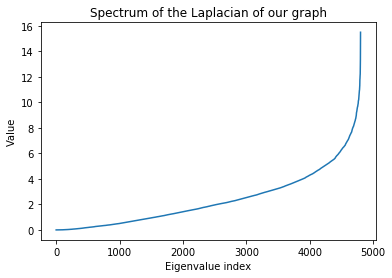

In [24]:
plt.plot(eigenvalues)
plt.xlabel('Eigenvalue index')
plt.ylabel('Value')
plt.title('Spectrum of the Laplacian of our graph')
plt.show()

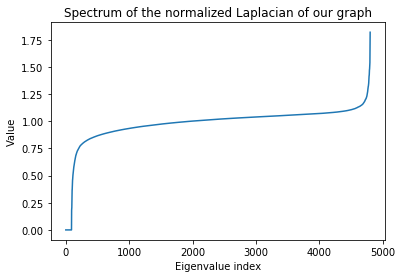

In [25]:
plt.plot(eigenvaluesNorm)
plt.xlabel('Eigenvalue index')
plt.ylabel('Value')
plt.title('Spectrum of the normalized Laplacian of our graph')
plt.show()

**Your answer here.**

When we look at the plot of the spectrum of the normalized Laplacian, we can see that there is no step change in the spectrum which means that our graph has no evident clusters but the biggest component in it. Indeed such step would indicate the number of intrinsic clusters in the graph. We also see that at some point (around eigenvalue #4500), the degree of respective nodes starts raising exponentially. 

Looking at the spectrum of the normalized Laplacian, it is easier to see null eigenvalues, which indicate that there are a few nodes disconnected from the biggest component.This spectrum shows better the nature of our graph, formed of a single cluster and a few disconnected nodes.

How many connected components are there in your graph? Answer using the eigenvalues only.

In [26]:
# Multiplicity of eigenvalue 0 gives connectedness of graph
TOLERANCE = 1e-14
zero_multiplicity = np.sum(eigenvalues < TOLERANCE)

print("The multiplicity of eigenvalue 0 gives connectedness of graph: our graph has {mult} components".format(mult=zero_multiplicity))

The multiplicity of eigenvalue 0 gives connectedness of graph: our graph has 91 components


Is there an upper bound on the eigenvalues, i.e., what is the largest possible eigenvalue? Answer for both the combinatorial and normalized Laplacians.

**Your answer here.**

In [27]:
print('The maximum of the eigenvalues of the combinatorial laplacian matrix: {max_eig:.3f}'.format(max_eig=eigenvalues.max()))
print('The maximum degree of our graph: {max_graph:.3f}'.format(max_graph=degree_weighted_imdb.max()))

The maximum of the eigenvalues of the combinatorial laplacian matrix: 15.505
The maximum degree of our graph: 15.367


The upper bound on the eigenvalues in the combinatorial Laplacian is the maximum node degree of the graph. Here it is 15.505. Note that we are using the weighted adjancency matrix.

## 2 Laplacian eigenmaps

*Laplacian eigenmaps* is a method to embed a graph $\mathcal{G}$ in a $d$-dimensional Euclidean space.
That is, it associates a vector $z_i \in \mathbb{R}^d$ to every node $v_i \in \mathcal{V}$.
The graph $\mathcal{G}$ is thus embedded as $Z \in \mathbb{R}^{N \times d}$.

### Question 7

What do we use Laplacian eigenmaps for? (Or more generally, graph embeddings.)

**Your answer here.**

**Graph Embeddings and especially Laplacian eigenmaps are used to reduce the dimension of the dataset in order to help with computation time and help to visualize the data.**

### Question 8

Embed your graph in $d=2$ dimensions with Laplacian eigenmaps.
Try with and without re-normalizing the eigenvectors by the degrees, then keep the one your prefer.

**Recompute** the eigenvectors you need with a partial eigendecomposition method for sparse matrices.
When $k \ll N$ eigenvectors are needed, partial eigendecompositions are much more efficient than complete eigendecompositions.
A partial eigendecomposition scales as $\Omega(k |\mathcal{E}|$), while a complete eigendecomposition costs $\mathcal{O}(N^3)$ operations.

**OBSERVATIONS**

**We got the biggest connected component of our graph from the first Milestone and saved it locally. We will use it for the following questions.**

**We redo the eigendecomposition with the laplacian from this new graph.**

In [28]:
biggest_adjacency =  np.load(DATA_PATH + 'biggest_adjacency.npy')
n_nodes_b =  len(biggest_adjacency)

In [29]:
biggest_degree_weighted_imdb = biggest_adjacency.sum(1)

D = np.diag(biggest_degree_weighted_imdb)

D_norm = np.diag(np.sqrt(1./biggest_degree_weighted_imdb))

D_norm[D_norm == np.inf] = 0

laplacian_combinatorial = sparse.csr_matrix(D - biggest_adjacency)
laplacian_normalized = sparse.csr_matrix(D_norm@laplacian_combinatorial@D_norm)

We embed our network in the first two dimensions and take only the real part of the resulting eigenvectors

In [30]:
b_eigenvalues, b_eigenvectors = scipy.sparse.linalg.eigsh(laplacian_combinatorial, k=3, which = 'SA')
b_eigenvalues_norm, b_eigenvectors_norm = scipy.sparse.linalg.eigsh(laplacian_normalized, k=3, which = 'SA')
assert b_eigenvectors.shape == (n_nodes_b, 3)

In [31]:
# We now need to compute the projections
# Without normalising
projection_x = np.matmul(biggest_adjacency,b_eigenvectors[:,1])
projection_y = np.matmul(biggest_adjacency,b_eigenvectors[:,2])

# With normalising
#b_eigenvectors_norm = D_norm.dot(b_eigenvectors)
projection_x_norm = np.matmul(biggest_adjacency,b_eigenvectors_norm[:,1])
projection_y_norm = np.matmul(biggest_adjacency,b_eigenvectors_norm[:,2])

Plot the nodes embedded in 2D. Comment on what you see.

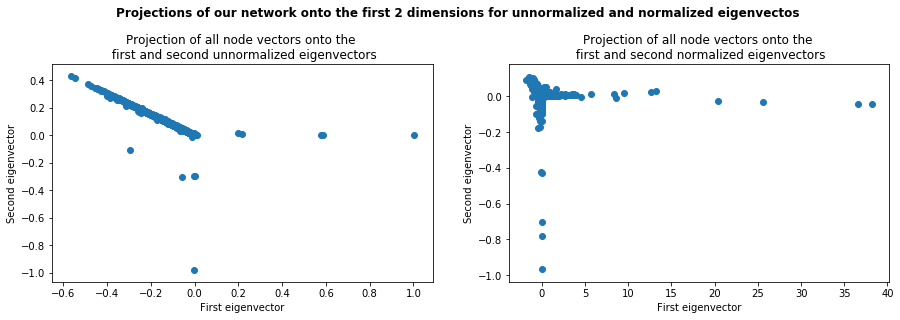

In [32]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
f.suptitle("Projections of our network onto the first 2 dimensions for unnormalized and normalized eigenvectos", y=1.08, fontweight="bold")

ax1.scatter(x=projection_x,y=projection_y)
ax1.set_title("Projection of all node vectors onto the \n first and second unnormalized eigenvectors")
ax1.set_ylabel("Second eigenvector")
ax1.set_xlabel("First eigenvector")

        
ax2.scatter(x=projection_x_norm,y=projection_y_norm)
ax2.set_title("Projection of all node vectors onto the \n first and second normalized eigenvectors")
ax2.set_ylabel("Second eigenvector")
ax2.set_xlabel("First eigenvector")

plt.show()

**Your answer here.**

We can observe from these graphs that the datapoints projected onto the two first eigenvectors are mostly grouped in a tightly packed cluster that can actually be described by one dimension (the line $f(x) = -x$ in the unnormalized projection).

There are a few points that lie outside of that cluster that can be separated into two categories: a few points that can be explained only by the first eigenvector and a few points that can be explained only by the second.

In the normalized projection, the elongated cluster becomes a globular, very tight one. This projection seems to be more adequate, since it is clear that these points belong in the same category and the normalized projection further clusters these points. The outliers however are left unchanged. 

This projection, even though it bears information about our graph (there is variance along both eigenvectors) only helps us distinguish one big cluster and a few outliers. In the following questions we will try to project the data onto different combinations of pairs of eigenvectors to see which eigenvectors bear more information about our network.

### Question 9

What does the embedding $Z \in \mathbb{R}^{N \times d}$ preserve?

**Your answer here.**

The embedding provided by the Laplacian eigenmap algorithm preserves local information and structure. Traditional techniques like PCA do not consider the intrinsic geometry of the data. Laplacian eigenmaps however builds a graph from neighborhood information of the data set. This method conserves the information about local connectivity of each node related to others, hence the local geometry. 

http://www2.imm.dtu.dk/projects/manifold/Papers/Laplacian.pdf 

## 3 Spectral clustering

*Spectral clustering* is a method to partition a graph into distinct clusters.
The method associates a feature vector $z_i \in \mathbb{R}^d$ to every node $v_i \in \mathcal{V}$, then runs [$k$-means](https://en.wikipedia.org/wiki/K-means_clustering) in the embedding space $\mathbb{R}^d$ to assign each node $v_i \in \mathcal{V}$ to a cluster $c_j \in \mathcal{C}$, where $k = |\mathcal{C}|$ is the number of desired clusters.

For this question, we wish to cluster our nodes (i.e. the movies) according to which movie genre they belong. Our dataset includes movies whose features are their cast and crew. We wish to see if these features are enough to infer the correct movie genre clustering without having the actual genre within the features. First, we load the movie genres from the actual dataset by taking only the nodes belonging to the biggest component. This function below returns the component to which each node belongs.

In [33]:
def find_components(adjacency):
    """Find the connected components of a graph.
    
    Parameters
    ----------
    adjacency: numpy array
        The (weighted) adjacency matrix of a graph.
    
    Returns
    -------
    list of numpy arrays
        A list of adjacency matrices, one per connected component.
    """
    
    # Convert adjacency matrix into an adjacency list
    # This makes it easier to navigate through the nodes
    adj_list = []
    for i in range(0, len(adjacency)):
        adj_list.append(list(np.nonzero(adjacency[i])[0]))
        
    # Each node will be assigned a label (starting from 1) according 
    # to which connected component it belongs. If the label is 0, 
    # it means it has not been visited yet.
    nodes = np.zeros(len(adjacency))
    # n counts the number of connected components
    n = 0
    
    while (np.count_nonzero(nodes) != len(adjacency)):
        n = n+1
        # We start from the first node that has not been visited
        start = np.where(nodes == 0)[0][0]
        queue = []
        visited = set()

        queue.append(start)
        visited.add(start)

        while queue:
            current = queue.pop(0)
            for node in adj_list[current]:
                if node not in visited:
                    queue.append(node)
                    visited.add(node)
        
        visited = list(visited)
        # Visited nodes are assigned their label
        nodes[visited] = n
        
    return nodes

In [34]:
# Load the features and extract the genres
features = pd.read_pickle(DATA_PATH + 'features.csv')
genres = features.genres

# Find the nodes that belong to the biggest component
nodes = find_components(adjacency)
idx = [i for i in range(len(nodes)) if nodes[i] == 1]

# Take only the genres of the nodes from the biggest component
genres = genres[idx].reset_index(drop=True)

# Convert to list and set in order to count how many different genres
genres_list = sum(list(genres.apply(lambda x: list(pd.read_json(x, dtype=False).name) if x != '[]' else [])), [])
genres_set = set(genres_list)
print("The number of different movie genres in our dataset is:", len(genres_set))

KeyError: 44

### Question 10

Choose $k$ and $d$. How did you get to those numbers?

**Your answer here.**

$k$ needs to be the number of movie genres. Knowing that we have 20 different movie genres in our dataset, we hence have $k = 20$.

We $d$ so that the visualization of the data is intuitive to the reader. We hence choose $d = 2$.

### Question 11

1. Embed your graph in $\mathbb{R}^d$ as $Z \in \mathbb{R}^{N \times d}$.
   Try with and without re-normalizing the eigenvectors by the degrees, then keep the one your prefer.
   
2. If you want $k=2$ clusters, partition with the Fiedler vector. For $k > 2$ clusters, run $k$-means on $Z$. Don't implement $k$-means, use the `KMeans` class imported from scikit-learn.

**1. Embed your graph in $\mathbb{R}^d$ as $Z \in \mathbb{R}^{N \times d}$.
   Try with and without re-normalizing the eigenvectors by the degrees, then keep the one your prefer.**
   
   We have already extracted the biggest laplacian. We will use this in order to embed our graph into the first 2 dimensions.

In [ ]:
# Comuputation of the embedded graph onto the 20 first dimensions
# We will then select the ones for which the projections have the clearest clusters
eigenval, eigenvect = scipy.sparse.linalg.eigs(biggest_laplacian, k=20, which = 'SR')
assert eigenvect.shape == (n_nodes_b, 20)
eigenvect = np.real(eigenvect)

After trying multiple combinations of eigenvectors, we chose the 1st and 4th because they are the ones that contain more information.

In [ ]:
# 1. Without re-normalizing: F
proj_x = np.matmul(biggest_adjacency, eigenvect[:,3])
proj_y = np.matmul(biggest_adjacency, eigenvect[:,1])

# 2. With re-normalizing: H = D^(-1/2) * F
eigenvect_norm = D_norm.dot(eigenvect)
proj_x_norm = np.matmul(biggest_adjacency, eigenvect_norm[:,3])
proj_y_norm = np.matmul(biggest_adjacency, eigenvect_norm[:,1])

In [ ]:
# We plot both projections in order to see which one has more clear clusters
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
f.suptitle("Projections of our network onto 2 dimensions for unnormalized and normalized eigenvectos", y=1.08, fontweight="bold")

ax1.scatter(x=proj_x,y=proj_y)
ax1.set_title("Projection of all node vectors onto the \n first and second unnormalized eigenvectors")
ax1.set_ylabel("Second eigenvector")
ax1.set_xlabel("Fourth eigenvector")

        
ax2.scatter(x=proj_x_norm,y=proj_y_norm)
ax2.set_title("Projection of all node vectors onto the \n first and second normalized eigenvectors")
ax2.set_ylabel("Second eigenvector")
ax2.set_xlabel("Fourth eigenvector")

plt.show()

We can see that the projected nodes are closely packed when using the normalized eigenvectors. We decided to use the normalized ones since in practice the eigenvectors are “re-normalized” by the degrees before k-means, because these are real cluster assignments.

In [ ]:
H = np.zeros((n_nodes_b, 2))
H[:,0] = eigenvect_norm[:,0] 
H[:,1] = eigenvect_norm[:,3]

X = np.zeros((n_nodes_b, 2))
X[:,0] = np.matmul(biggest_adjacency, eigenvect[:,3])
X[:,1] = np.matmul(biggest_adjacency, eigenvect[:,0])

**2. If you want $k=2$ clusters, partition with the Fiedler vector. For $k > 2$ clusters, run $k$-means on $Z$. Don't implement $k$-means, use the `KMeans` class imported from scikit-learn.**

In [ ]:
# Since we have k=20, we have to run k-means on Z
kmeans = KMeans(n_clusters=20)  
kmeans.fit(H)
centers = kmeans.cluster_centers_
labels = kmeans.labels_

### Question 12

Use the computed cluster assignment to reorder the adjacency matrix $A$.
What do you expect? What do you observe?

In [ ]:
# The new order is the index of the sorted labels resulting form k-means
new_order = sorted(range(len(labels)), key=lambda k: labels[k])
ordered_adjacency = biggest_adjacency[:, new_order][new_order]

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))
f.suptitle("Original and ordered adjacency matrix of our network's biggest", fontweight="bold")

ax1.spy(biggest_adjacency, markersize=0.01)
ax1.set_title("Original adjacency matrix \n")
        
ax2.spy(ordered_adjacency, markersize=0.01)
ax2.set_title("Re-ordered adjacency matrix \n")

plt.show()

In [ ]:
genres_set

**Your answer here.**

In order to re-order our matrix, we sorted the labels list so as to put all labels together and used the indexes of the sorted list to re-order our matrix.

We expected one cluster to be significantly bigger than the others. This is because we know already that our network is scale-free and that some nodes have a very high degree compared to other nodes that are further away (and are hence less connected). However, we also expected to see all 20 clusters (even if they were small), but looking at the figures in question 11 the outliers are propably causing the creation of extremely small clusters that can't be visible.

### Question 13

If you have ground truth clusters for your dataset, compare the cluster assignment from spectral clustering to the ground truth.
A simple quantitative measure is to compute the percentage of nodes that have been correctly categorized.
If you don't have a ground truth, qualitatively assess the quality of the clustering.

Ground truth clusters are the "real clusters".
For example, the genre of musical tracks in FMA, the category of Wikipedia articles, the spammer status of individuals, etc.
Look for the `labels` in the [dataset descriptions](https://github.com/mdeff/ntds_2018/tree/master/projects/README.md).

In [ ]:
import collections
for k in range(0, 20):
    idx = [i for i in range(len(labels)) if labels[i] == k]
    genres_k = genres[idx].reset_index(drop=True)
    genres_k = genres_k.apply(lambda x : list(pd.read_json(x, dtype=False).name) if x != '[]' else [])
    list_genres = sum(genres_k, [])
    counter=collections.Counter(list_genres)
    print("Cluster label:", k)
    print("Number of nodes:", len(idx))
    print("Genre occurrences:")
    print(counter)
    print("\n")
    

**Answer:**

In our original network, we have some labels: the movie genres. However, we can have up to 3 movie genres per node (i.e. per movie). This makes it very hard to evaluate the result of the clustering: we set K to be 20, meaning that the clustering would classify each node as belonging to only one movie genre. If the actual label contains 3 movie genres, how can we tell if it is accurate or not? Moreover, once we have the clustering assignments, how do we assign the correct labels to the clustering labels (i.e. which movie genre goes with which clustering label)?

Due to these problems, we decided to evaluate the clustering qualitatively. We can see that the clusters are uneven: we obtain clusters having between 1 and 1892 nodes. We can also see that the clustering does not discriminate movie genres at all: we only have a very short list of genres per cluster when the cluster is made of 1 or 2 nodes. When the cluster is bigger than that, there appears to be no coherency between the genres **within one cluster**. 

This result is not surprising as the clustering was made using the number of co-appearances of cast and crew between movies. Intuitively, there is no reason why most actors or crew members should only appear in the same kind of movies. Furthermore, K-means assigns each film to only one cluster but this is flawed as we know from the start that a lot of movies can be included in at least three different clusters (there are movies that have 3 genres in the dataset). This is confirmed by this clustering result.

In order to assess the quality of the clusters per se, we used the Silhouette coefficient. This metric gives negative coefficients for incorrect clusters, a coefficient around 0 when the clusters' centers overlap and 1 for perfect clustering.

In [ ]:
silh_coeff = metrics.silhouette_score(H, labels, metric='euclidean')
print('Silhouette coefficient of our clustering: {coeff:.3f}'.format(coeff=silh_coeff))

Since have a relatively good silhouette score, we can infer that the quality of the clusters is not bad per se. On the other hand the clusters do not make any significant separation of genres, which suggests us that K-means is not a good way to separate our graph. 

### Question 14

Plot the cluster assignment (one color per cluster) on the 2D embedding you computed above with Laplacian eigenmaps.

In [ ]:
import matplotlib as mpl

# Your code here.
cmap_20 = mpl.colors.ListedColormap(['red', 'deeppink', 'magenta', 'plum', 
                                  'mediumorchid', 'mediumpurple', 'royalblue', 'deepskyblue', 
                                  'darkturquoise', 'cyan', 'mediumspringgreen', 'lime', 
                                  'yellow', 'gold', 'orange', 'darkorange', 
                                  'sandybrown', 'coral', 'firebrick', 'maroon'])

plt.figure(figsize=(10, 10))
plt.scatter(x=proj_x_norm,y=proj_y_norm, c=labels, cmap=cmap_20)
norm = mpl.colors.Normalize(vmin=0,vmax=19)
sm = plt.cm.ScalarMappable(cmap=cmap_20, norm=norm)
sm.set_array([])

plt.colorbar(sm, ticks=np.linspace(0,19,20), 
             boundaries=np.arange(0,20,1))
plt.title("Cluster assignment on the 2D embedding of our network")
plt.xlabel("Fourth eigenvector")
plt.ylabel("Second eigenvector")

plt.show()

The clusters overlap.

### Question 15

Why did we use the eigenvectors of the graph Laplacian as features? Could we use other features for clustering?

**Your answer here.**

Spectral clustering techniques use the spectrum (eigenvalues) of a certain similarity matrix of the data to perform dimensionality reduction before clustering in fewer dimensions. The similarity matrix is an assessment of the relative similarity of each pair of nodes in the graph. Here, the similarity matrix used is the Graph Laplacian. Indeed, the Laplacian L = D - A contains for each node the number of edges it has with other nodes, which is a measure of similarity. 

We use the eigenvectors instead of our actual Laplacian in order to be able to perform the dimensionality reduction. This makes it easier to visualize the clusters and to keep only the relevant information.

Another solution could have been to use our actual data projected onto the selected eigenvectors, or just the whole graph without the dimensionality reduction. 